# Fully-saturated TWFE

In [130]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from patsy import dmatrix

import pymc as pm
import pymc_experimental.statespace.models.structural as st
import pytensor.tensor as pt
import arviz as az
az.style.use('arviz-darkgrid')

rng = np.random.default_rng(42)
figsize = (10, 5)

In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df = df.dropna(subset=['population'])
df.loc[df['treatment_group'] == 0, 'time_since_treatment'] = np.nan # コントロール群の処置後経過年数は欠損値
df['time_since_treatment'] = np.nan_to_num(df['time_since_treatment'], nan=1000)

df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_id, mn_island_ids = df.island_ids.factorize()

df.bridge_year = df.bridge_year.astype(str)
df.bridge_year = df.bridge_year.map(str.strip)
bridge_year, mn_bridge_years = df.bridge_year.factorize()

$$
\begin{aligned}
\log{Y^{**}_{it}} &\sim \mathcal{t} (\nu, \mu_{it}, \sigma_i^2) \\
\nu &\sim \text{Exponential}(1/10) \\
\mu_{it} &= \alpha + \beta_{gl} \cdot T_{i} \\
\alpha &\sim \mathcal{N}(0, 0.1^2) \\
\beta_{gl} &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) \\
\sigma_i &\sim \mathcal{C}^+(\sigma_0^2) \\
\end{aligned}
$$

- $\beta_{gl}$: 介入時期 $g$ と介入経過時間 $l$ によって変動する介入効果
- $T_{it}$: 介入群ダミー
- $\mu_{\beta} \sim N(0, 0.3^2)$: 介入時期と介入経過時間の期待値を表すハイパーパラメータ
- $\sigma_{\beta}^2 \sim N^+(0.3^2)$: 介入時期と介入経過時間の分散を表すハイパーパラメータ
- $\sigma_0^2 \sim N^+(0.24^2)$: 島間の誤差分散を表すハイパーパラメータ
- $\sigma_i^2$: 島間の誤差分散

## サンプリングのインポート

In [3]:
trace_homo = az.from_netcdf('./mcmc_sample/fully_saturated/homo_kokucho_20250109.nc')

## 階層ベイズモデル 不均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


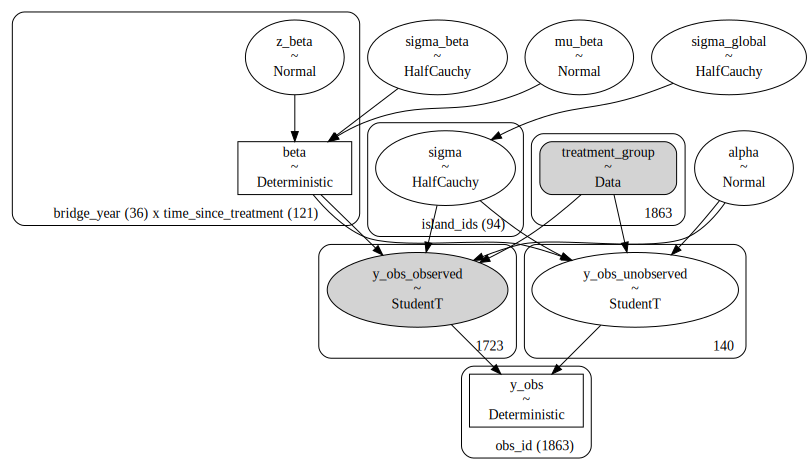

In [4]:
COORDS = {
    'obs_id': df.index,
    'island_ids': mn_island_ids,
    'bridge_year': mn_bridge_years,
    'time_since_treatment': mn_time_since_treatments,
}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    # island_ids = pm.Data('island_ids', island_ids)
    # bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    # time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.1)
    sigma_beta = pm.HalfCauchy('sigma_beta', 0.1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, dims=('bridge_year', 'time_since_treatment'))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta, dims=('bridge_year', 'time_since_treatment'))

    # sigma
    sigma_global = pm.HalfCauchy('sigma_global', 0.15)
    sigma = pm.HalfCauchy('sigma', sigma_global, dims='island_ids')

    # fixed effects
    alpha = pm.Normal('alpha', mu=0, sigma=0.1)
    nu = 7

    # expected value
    mu = alpha + beta[bridge_year, time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma[island_id], nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_hetero)

In [5]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=2500,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng,
        target_accept=0.95, # これを設定しないとチェーンが動かない
    )

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [1]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/hie_hetero_const_20250108.nc')

NameError: name 'az' is not defined

In [1]:
# サンプリングの保存
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/hie_hetero_const_20250108.nc')

NameError: name 'az' is not defined

In [7]:
az.summary(trace_h_hetero, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma_global',], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.024,0.004,0.017,0.031,0.000,0.0,340.0,469.0,1.02
mu_beta,-0.055,0.009,-0.072,-0.038,0.000,0.0,366.0,1046.0,1.11
sigma_beta,0.123,0.007,0.110,0.139,0.001,0.0,128.0,137.0,1.05
sigma_global,0.135,0.017,0.104,0.171,0.001,0.0,760.0,2742.0,1.06


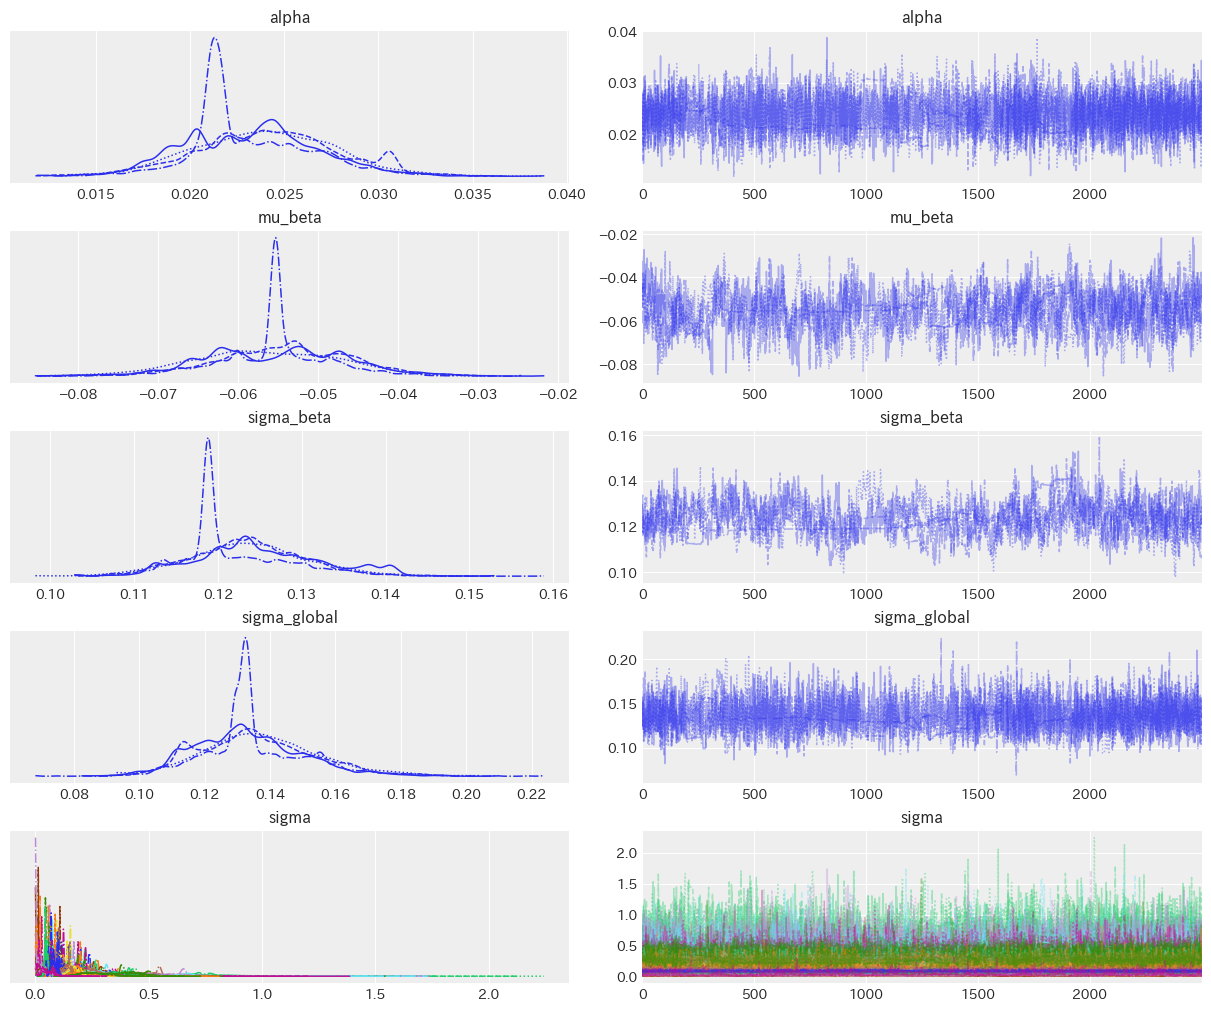

In [8]:
az.plot_trace(trace_h_hetero, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma_global', 'sigma']);

## 階層ベイズモデル 均一分散

In [3]:
bridge_year_list = df['bridge_year'].unique()
bridge_year_list.sort()
bridge_year_list

array(['0', '1970', '1972', '1973', '1975', '1976', '1979', '1982',
       '1983', '1987', '1988', '1989', '1991', '1992', '1995', '1996',
       '1997', '1998', '1999', '2000', '2004', '2008', '2011', '2015',
       '2016'], dtype=object)

In [5]:
fully_saturated = dmatrix('C(bridge_year):C(time_since_treatment) - 1', df, return_type='dataframe')
fully_saturated = fully_saturated.loc[:, (fully_saturated != 0).any(axis=0)] # 全て0の列を削除
fully_saturated.drop(
    columns=['C(bridge_year)[0]:C(time_since_treatment)[1000.0]'], # コントロール群を削除
    axis=1, inplace=True
)
fully_saturated

,C(bridge_year)[2016]:C(time_since_treatment)[-46.0],C(bridge_year)[2015]:C(time_since_treatment)[-45.0],C(bridge_year)[2011]:C(time_since_treatment)[-41.0],C(bridge_year)[2016]:C(time_since_treatment)[-41.0],C(bridge_year)[2015]:C(time_since_treatment)[-40.0],C(bridge_year)[2011]:C(time_since_treatment)[-36.0],C(bridge_year)[2016]:C(time_since_treatment)[-36.0],C(bridge_year)[2015]:C(time_since_treatment)[-35.0],C(bridge_year)[2004]:C(time_since_treatment)[-34.0],C(bridge_year)[2008]:C(time_since_treatment)[-33.0],...,C(bridge_year)[1975]:C(time_since_treatment)[40.0],C(bridge_year)[1979]:C(time_since_treatment)[41.0],C(bridge_year)[1973]:C(time_since_treatment)[42.0],C(bridge_year)[1972]:C(time_since_treatment)[43.0],C(bridge_year)[1976]:C(time_since_treatment)[44.0],C(bridge_year)[1970]:C(time_since_treatment)[45.0],C(bridge_year)[1975]:C(time_since_treatment)[45.0],C(bridge_year)[1973]:C(time_since_treatment)[47.0],C(bridge_year)[1972]:C(time_since_treatment)[48.0],C(bridge_year)[1970]:C(time_since_treatment)[50.0]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


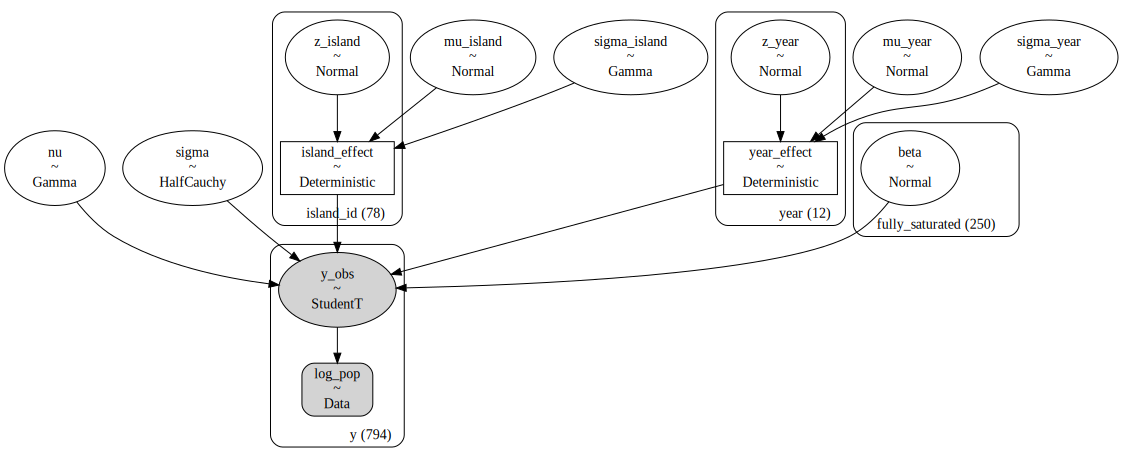

In [6]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'fully_saturated': fully_saturated.columns,
}

with pm.Model(coords=COORDS) as model_homo:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    # treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    # after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect
    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    # fixed effect
    beta = pm.Normal('beta', mu=0, sigma=1, dims='fully_saturated')
    sigma = pm.HalfCauchy('sigma', beta=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(fully_saturated, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop, dims='y')

pm.model_to_graphviz(model_homo)

In [7]:
with model_homo:
    trace_homo = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
az.to_netcdf(trace_homo, './mcmc_sample/fully_saturated/homo_20250111.nc')

'./mcmc_sample/fully_saturated/homo_20250111.nc'

In [9]:
az.summary(trace_homo, var_names=['sigma', 'nu', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.137,0.011,0.116,0.160,0.000,0.000,2192.0,3770.0,1.0
nu,2.446,0.374,1.766,3.181,0.006,0.005,3402.0,5205.0,1.0
mu_island,5.930,0.490,4.968,6.890,0.008,0.005,4080.0,4065.0,1.0
sigma_island,1.975,0.164,1.674,2.311,0.004,0.003,1916.0,3461.0,1.0
mu_year,-0.193,0.481,-1.112,0.762,0.006,0.005,7340.0,4621.0,1.0
sigma_year,0.626,0.159,0.372,0.946,0.002,0.002,5119.0,5257.0,1.0


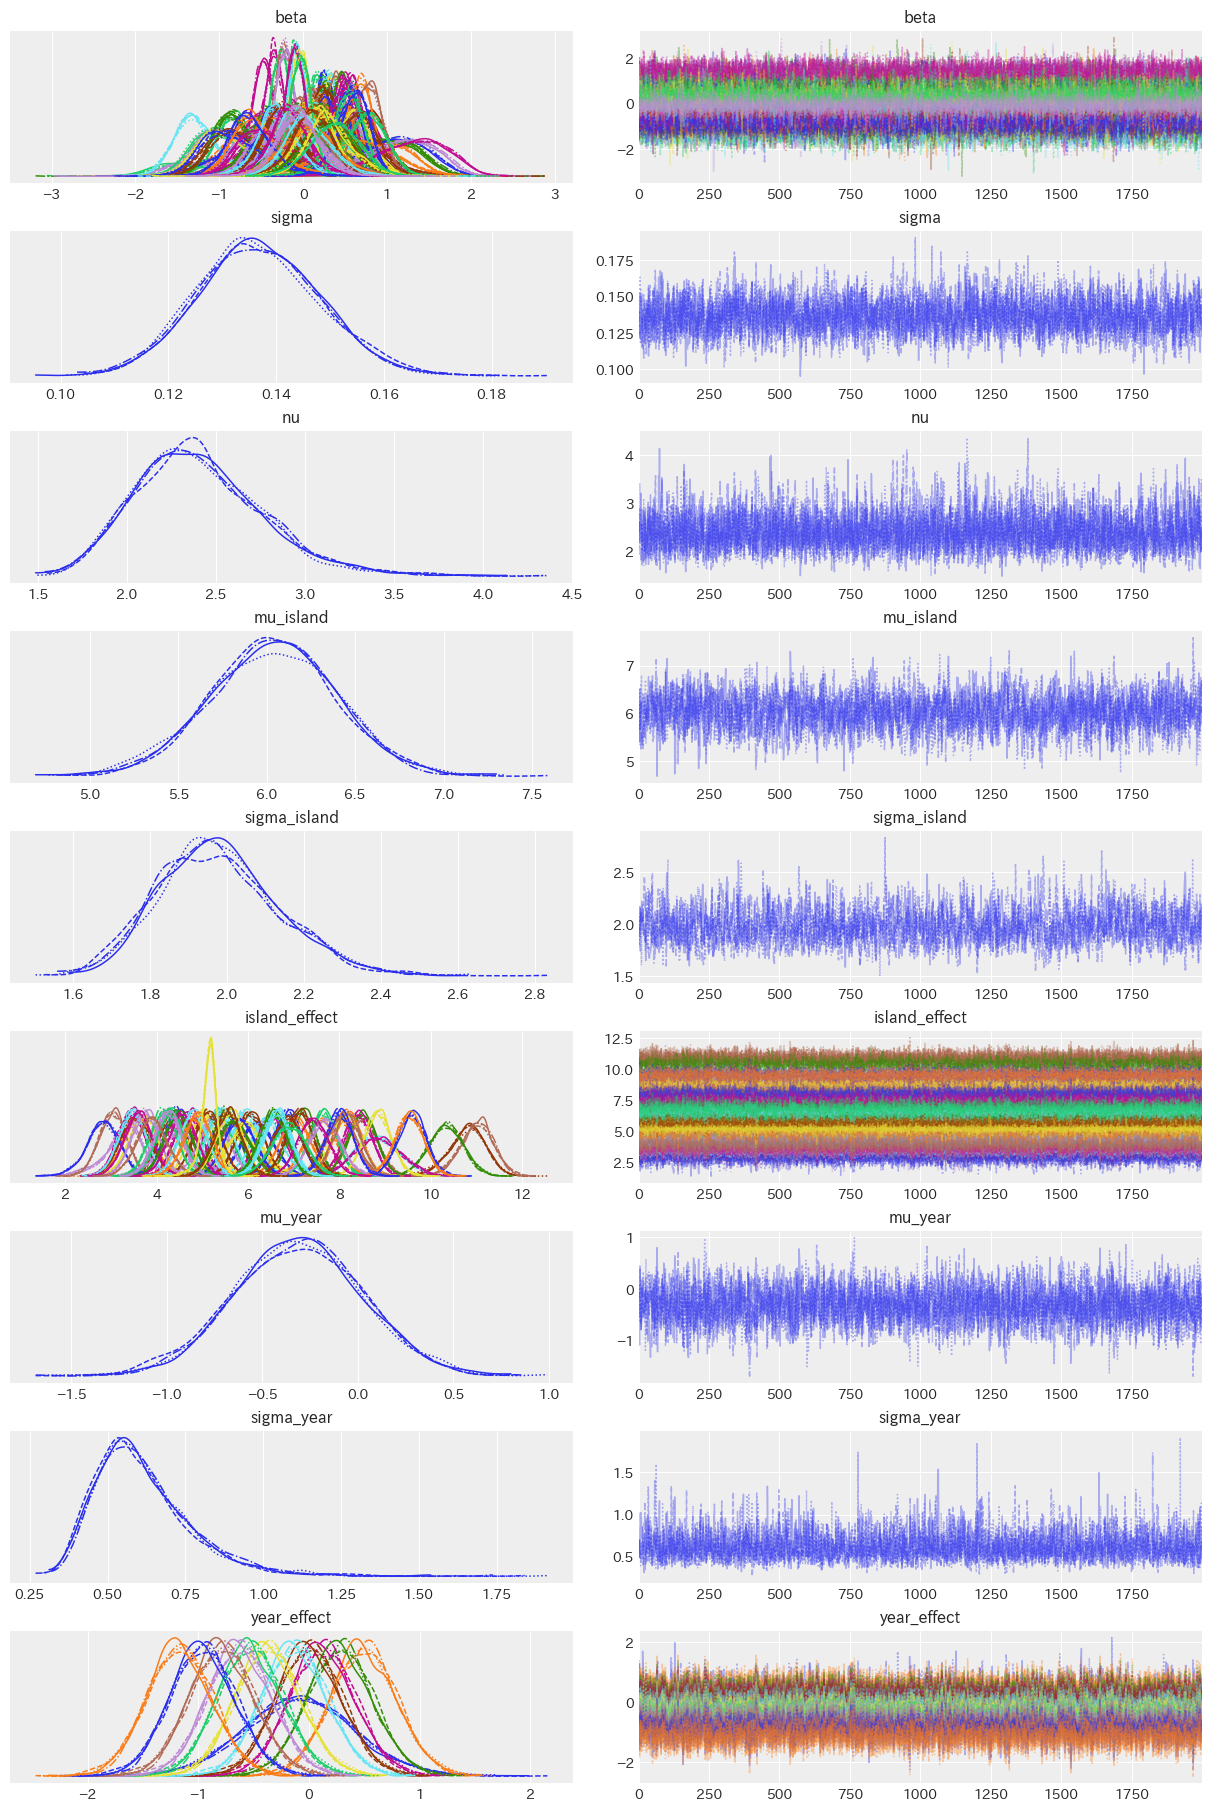

In [16]:
az.plot_trace(trace_homo, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island', 'island_effect', 'mu_year', 'sigma_year', 'year_effect']);

In [31]:
with model_homo:
    pm.compute_log_likelihood(trace_homo)

Output()

In [32]:
az.waic(trace_homo)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 782 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -164.36    30.48
p_waic      375.17        -

There has been a warning during the calculation. Please check the results.

## ウェイトの計算

In [10]:
beta_df = az.summary(trace_homo, var_names=['beta'], hdi_prob=0.95)
# 正規表現でbridge_yearとtime_since_treatmentを抽出
pattern = r'C\(bridge_year\)\[(\d+)\]:C\(time_since_treatment\)\[(-?\d+)\.0\]'
extracted = beta_df.index.str.extract(pattern)
extracted.index = beta_df.index
beta_df['bridge_year'] = extracted[0].astype(int)
beta_df['time_since_treatment'] = extracted[1].astype(int)
beta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, beta[C(bridge_year)[2016]:C(time_since_treatment)[-46.0]] to beta[C(bridge_year)[1970]:C(time_since_treatment)[50.0]]
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean                  250 non-null    float64
 1   sd                    250 non-null    float64
 2   hdi_2.5%              250 non-null    float64
 3   hdi_97.5%             250 non-null    float64
 4   mcse_mean             250 non-null    float64
 5   mcse_sd               250 non-null    float64
 6   ess_bulk              250 non-null    float64
 7   ess_tail              250 non-null    float64
 8   r_hat                 250 non-null    float64
 9   bridge_year           250 non-null    int64  
 10  time_since_treatment  250 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 23.4+ KB


In [11]:
beta_df = beta_df.sort_values(['bridge_year', 'time_since_treatment'])

In [12]:
beta_df.to_csv('../../data/processed/fully_saturated/homo.csv')

In [89]:
beta_df['cohort_size'] = beta_df.groupby(['bridge_year', 'time_since_treatment']).transform('size')

In [110]:
beta_df = beta_df.rename(columns={'hdi_2.5%': 'hdi_lwr', 'hdi_97.5%': 'hdi_upr'})

In [120]:
def weighted_mean(group):
    return (group['mean'] * group['cohort_size']).sum() / group['cohort_size'].sum()
def weighted_lwr(group):
    return (group['hdi_lwr'] * group['cohort_size']).sum() / group['cohort_size'].sum()
def weighted_upr(group):
    return (group['hdi_upr'] * group['cohort_size']).sum() / group['cohort_size'].sum()

weighted_means = beta_df.groupby('time_since_treatment', as_index=False).apply(weighted_mean)
weighted_lwrs = beta_df.groupby('time_since_treatment', as_index=False).apply(weighted_lwr)
weighted_uprs = beta_df.groupby('time_since_treatment', as_index=False).apply(weighted_upr)

weighted_means.columns = ['time_since_treatment', 'mean']
weighted_lwrs.columns = ['time_since_treatment', 'hdi_lwr']
weighted_uprs.columns = ['time_since_treatment', 'hdi_upr']
weighted_beta_df = pd.concat([weighted_means, weighted_lwrs['hdi_lwr'], weighted_uprs['hdi_upr']], axis=1)

/tmp/ipykernel_8572/3291302630.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_means = beta_df.groupby('time_since_treatment', as_index=False).apply(weighted_mean)
/tmp/ipykernel_8572/3291302630.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_lwrs = beta_df.groupby('time_since_treatment', as_index=False).apply(weighted_lwr)
/tmp/ipykernel_8572/3291302630.py:10: DeprecationWarning: 

Text(0, 0.5, '係数')

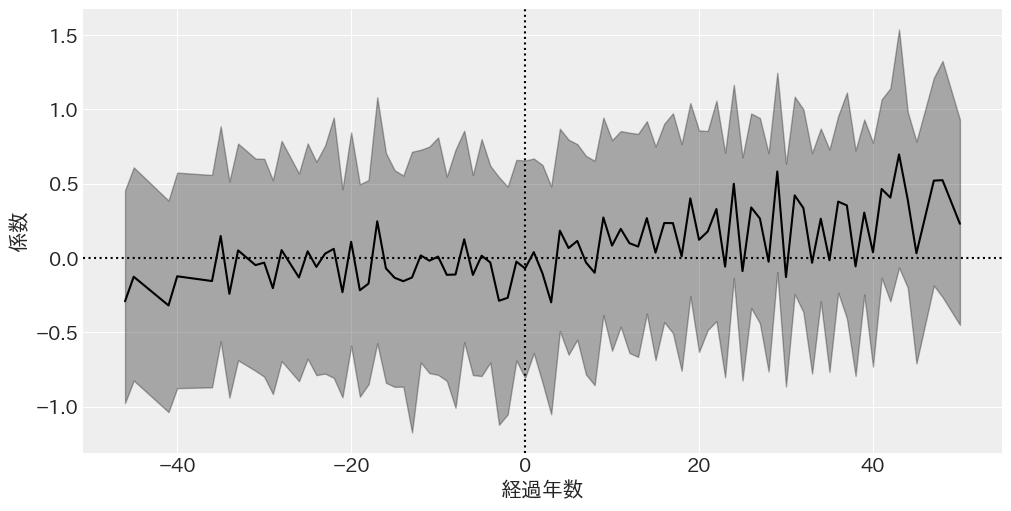

In [124]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x='time_since_treatment', y='mean', data=weighted_beta_df, color='black', ax=ax)
ax.fill_between(
    x=weighted_beta_df['time_since_treatment'],
    y1=weighted_beta_df['hdi_lwr'],
    y2=weighted_beta_df['hdi_upr'],
    alpha=0.3,
    color='black',
)
ax.axvline(0, color='black', ls=':')
ax.axhline(0, color='black', ls=':')
ax.set_xlabel('経過年数')
ax.set_ylabel('係数')

## スムージング

In [127]:
weighted_beta_df.head()

,time_since_treatment,mean,hdi_lwr,hdi_upr
0,-46,-0.291,-0.9750,0.454
1,-45,-0.126,-0.8240,0.609
2,-41,-0.319,-1.0355,0.386
3,-40,-0.123,-0.8750,0.574
4,-36,-0.155,-0.8695,0.558


In [128]:
# level (Smooth Trend)
ll = st.LevelTrendComponent(order=2)
# 観測誤差
er = st.MeasurementError()

mod = ll + er
ss_mod = mod.build()

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (2,), constraints: Positive, dims: ('trend_shock',)
	sigma_MeasurementError -- shape: (), constraints: Positive, dims: None
	P0 -- shape: (2, 2), constraints: Positive semi-definite, dims: ('state', 'state_aux')


In [131]:
with pm.Model(coords=ss_mod.coords) as model_smooth:
    # 初期値の分散
    P0_diag = pm.Gamma('P0_diag', alpha=2, beta=1, dims=['state'])
    P0 = pm.Deterministic('P0', pt.diag(P0_diag), dims=['state', 'state_aux'])
    
    # 初期値
    initial_trend = pm.Normal('initial_trend', sigma=1, dims=['trend_state'])
    
    # 状態変数の分散
    sigma_trend = pm.HalfCauchy('sigma_trend', beta=1, dims=['trend_shock'])
    sigma_MeasurementError = pm.HalfCauchy('sigma_MeasurementError', beta=1)
    
    
    ss_mod.build_statespace_graph(data=weighted_beta_df['mean'], mode='JAX')

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:92: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


In [132]:
with model_smooth:
    trace_smoothing = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42,
        target_accept=.998
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [133]:
az.to_netcdf(trace_smoothing, './mcmc_sample/fully_saturated/smoothing_20250111.nc')

'./mcmc_sample/fully_saturated/smoothing_20250111.nc'

In [134]:
az.summary(trace_smoothing, hdi_prob=0.95)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
initial_trend[level],-0.067,0.759,-1.537,1.456,0.010,0.009,6037.0,5116.0,1.0
initial_trend[trend],-0.005,0.745,-1.489,1.454,0.010,0.009,5812.0,4596.0,1.0
P0_diag[level],1.732,1.280,0.037,4.239,0.014,0.011,6173.0,3722.0,1.0
P0_diag[trend],1.703,1.260,0.018,4.145,0.015,0.010,5532.0,3748.0,1.0
sigma_trend[level],0.016,0.012,0.000,0.040,0.000,0.000,4476.0,2397.0,1.0
sigma_trend[trend],0.002,0.002,0.000,0.006,0.000,0.000,5758.0,3320.0,1.0
sigma_MeasurementError,0.170,0.014,0.144,0.196,0.000,0.000,7130.0,5166.0,1.0
"P0[level, level]",1.732,1.280,0.037,4.239,0.014,0.011,6173.0,3722.0,1.0
"P0[level, trend]",0.000,0.000,0.000,0.000,0.000,0.000,8000.0,8000.0,NaN
"P0[trend, level]",0.000,0.000,0.000,0.000,0.000,0.000,8000.0,8000.0,NaN


/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


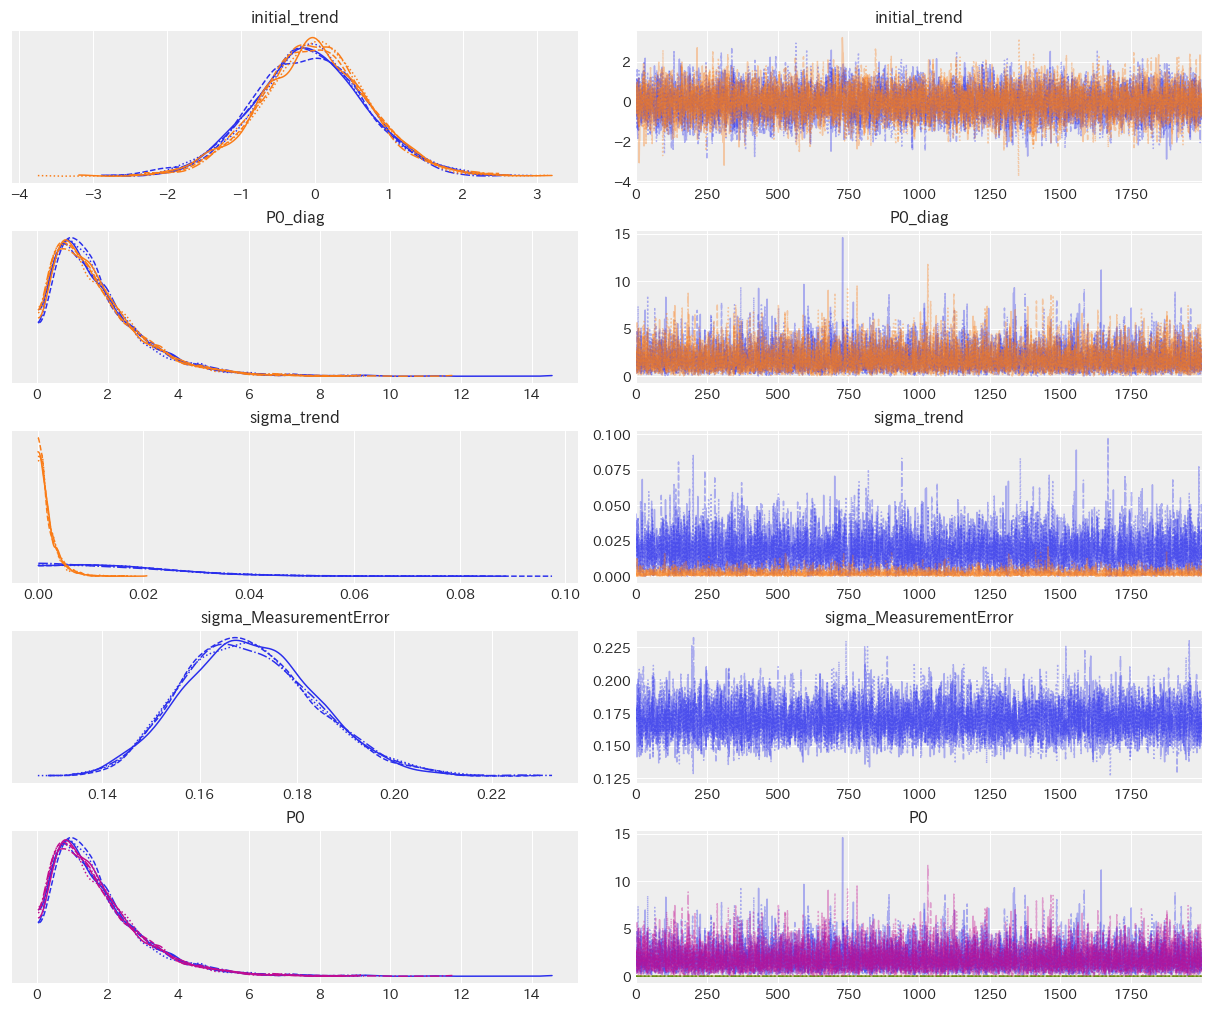

In [135]:
az.plot_trace(trace_smoothing);

In [136]:
post = ss_mod.sample_conditional_posterior(trace_smoothing)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:92: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F3DC43BA7A0>), RNG(<Generator(PCG64) at 0x7F3DC43BA6C0>), RNG(<Generator(PCG64) at 0x7F3DC43BA5E0>), RNG(<Generator(PCG64) at 0x7F3DC43BA500>), RNG(<Generator(PCG64) at 0x7F3DC43BA420>), RNG(<Generator(PCG64) at 0x7F3D82B8CD60>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  wa

Output()

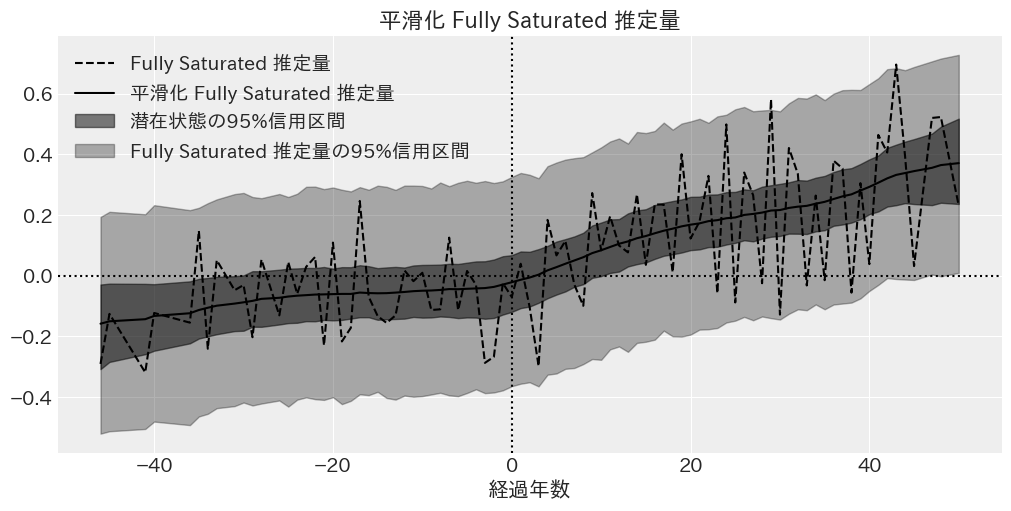

In [140]:
fig, ax = plt.subplots(figsize=(10, 5))

# 状態
data = post.smoothed_posterior.isel(state=0)
weighted_beta_df['smoothed_mean'] = data.mean(dim=['chain', 'draw']).values
hdi = az.hdi(data, hdi_prob=.95).smoothed_posterior
weighted_beta_df['state_smoothed_lwr_post'] = hdi[:len(weighted_beta_df), 0]
weighted_beta_df['state_smoothed_upr_post'] = hdi[:len(weighted_beta_df), 1]

# 観測
post_stacked = post.stack(sample=['chain', 'draw'])
hdi_post = az.hdi(post, hdi_prob=0.95).smoothed_posterior_observed.squeeze().values
weighted_beta_df['obs_smoothed_lwr_post'] = hdi_post[:, 0]
weighted_beta_df['obs_smoothed_upr_post'] = hdi_post[:, 1]

# sns.scatterplot(x='time_since_treatment', y='mean', data=weighted_beta_df, ax=ax, color='black', label='事後期待値')
sns.lineplot(x='time_since_treatment', y='mean', data=weighted_beta_df, ax=ax, color='black', label='Fully Saturated 推定量', ls='--')
ax.plot(
    weighted_beta_df['time_since_treatment'],
    weighted_beta_df['smoothed_mean'],
    label='平滑化 Fully Saturated 推定量',
    color='k',
)
ax.fill_between(
    weighted_beta_df['time_since_treatment'],
    y1=weighted_beta_df['state_smoothed_lwr_post'],
    y2=weighted_beta_df['state_smoothed_upr_post'],
    alpha=0.5, label='潜在状態の95%信用区間', color='k'
)
ax.fill_between(
    weighted_beta_df['time_since_treatment'],
    y1=weighted_beta_df['obs_smoothed_lwr_post'],
    y2=weighted_beta_df['obs_smoothed_upr_post'],
    alpha=0.3, label='Fully Saturated 推定量の95%信用区間', color='k'
)
ax.axvline(x=0, color='k', linestyle=':')
ax.axhline(y=0, color='k', linestyle=':')
ax.set_title('平滑化 Fully Saturated 推定量')
ax.set_xlabel('経過年数')
ax.set_ylabel('')
ax.legend()
path = '../../docs/figures/fully_saturated_twfe/smoothed_ATT.png'
plt.savefig(path)

In [141]:
path = '../../data/processed/fully_saturated/weighted_beta_smoothed.csv'
weighted_beta_df.to_csv(path)

## 年効果

In [13]:
year_effects = az.summary(trace_homo, var_names=['year_effect'], hdi_prob=.95)

In [14]:
pattern = r'year_effect\[C\(year\)\[(\d+)\]\]'
extracted = year_effects.index.str.extract(pattern)
extracted.index = year_effects.index
year_effects['year'] = extracted[0].astype(int)


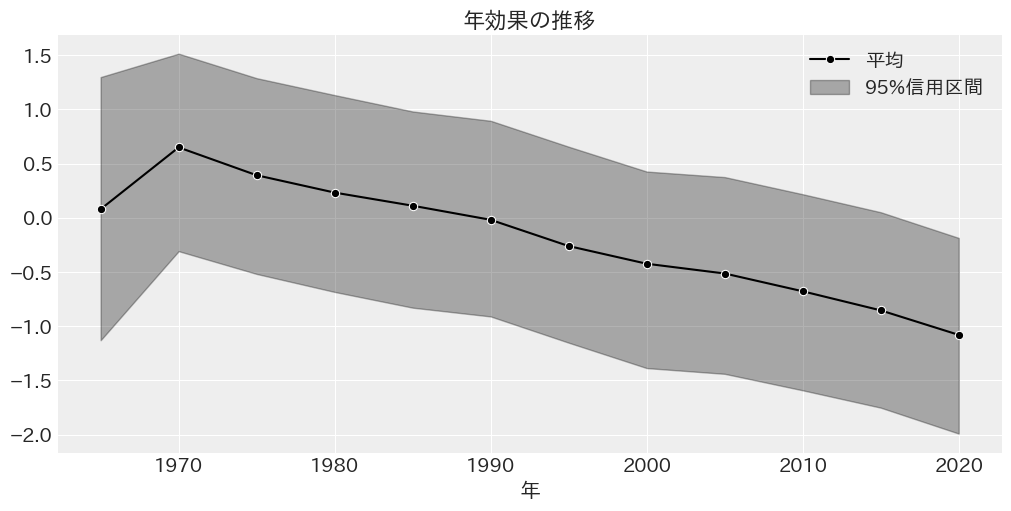

In [15]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x='year', y='mean', data=year_effects, ax=ax, marker='o', color='black', label='平均')
ax.fill_between(
    x='year',
    y1='hdi_2.5%',
    y2='hdi_97.5%',
    data=year_effects,
    color='black',
    alpha=0.3,
    label='95%信用区間'
)
ax.set_title('年効果の推移')
ax.set_xlabel('年')
ax.set_ylabel('')
ax.legend()

## サンプリングの保存

In [ ]:
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/trace_h_hetero.nc')
# az.to_netcdf(trace_h_homo, './mcmc_sample/fully_saturated/trace_h_homo.nc')

In [ ]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/hie_hetero.nc')